# Import required libraries

In [1]:
# Standard library imports
import datetime
import math
from copy import deepcopy
from typing import Literal, Iterable, Union

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Scikit-learn imports
from sklearn.base import BaseEstimator, clone
from sklearn.ensemble import StackingClassifier, StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
!python -V

Python 3.10.12


# Genetic Algorithm functions

## Initialize population

In [3]:
def initialize_population(num_individuals, num_variables, seed):
    np.random.seed(seed)
    pop = np.random.randint(2, size=(num_individuals, num_variables))
    return pop

## Crossover

In [4]:
def crossover(pop, mode: Literal["1X", "UX"] = "UX", seed=None, crossover_prob=0.5):
    np.random.seed(seed)
    num_individuals = len(pop)
    num_parameters = len(pop[0])
    indices = np.arange(num_individuals)
    np.random.shuffle(indices)
    offspring = []

    for i in range(0, num_individuals, 2):
        idx1 = indices[i]
        idx2 = indices[i + 1]
        offspring1 = list(pop[idx1])
        offspring2 = list(pop[idx2])

        if mode == "UX":
            for idx in range(0, num_parameters):
                r = np.random.rand()
                if r < crossover_prob:
                    temp = offspring2[idx]
                    offspring2[idx] = offspring1[idx]
                    offspring1[idx] = temp
        else:
            cross_point = np.random.randint(num_parameters - 1)
            for idx in range(cross_point, num_parameters):
                temp = offspring2[idx]
                offspring2[idx] = offspring1[idx]
                offspring1[idx] = temp

        offspring.append(offspring1)
        offspring.append(offspring2)

    offspring = np.array(offspring)
    return offspring

## Mutation

In [5]:
def mutation(pop, seed=None, mutation_prob=0.5):
    np.random.seed(seed)
    num_individuals = len(pop)
    num_parameters = len(pop[0])

    mutation_mask = np.random.choice([True, False],
                                     size=(num_individuals, num_parameters),
                                     p=[mutation_prob, 1 - mutation_prob])
    return np.where(mutation_mask, 1-pop, pop)

## Selection

In [6]:
def tournament_selection_for_popop(pop, pop_fitness, tournament_size, seed=None):
    assert pop.shape[0] == pop_fitness.shape[0]

    np.random.seed(seed)
    selected_indices = []
    indices = np.arange(pop.shape[0])

    for _ in range(2):
        np.random.shuffle(indices)

        tournament_groups = np.split(indices, np.arange(tournament_size, pop.shape[0], tournament_size))

        for group in tournament_groups:
            group_fitness = np.apply_along_axis(lambda x: pop_fitness[x], arr=group, axis=0)
            selected_indices.append(group[np.argmax(group_fitness)])

    selected_indices = np.array(selected_indices)
    return selected_indices

In [7]:
def truncation_selection(pop, pop_fitness, selection_size=None):
    assert pop.shape[0] == pop_fitness.shape[0]
    if selection_size is None:
        selection_size = pop.shape[0] // 2
    selected_indices = np.argsort(pop_fitness)[-selection_size:]
    return selected_indices

## Some misc functions

In [8]:
def merge_two_population(pop1, pop2):
    result_pop = np.vstack([pop1, pop2])
    return result_pop

def pop_from_selection(pop, selected_indices):
    result_pop = np.array([pop[i] for i in selected_indices])
    return result_pop

def is_converged(pop: np.ndarray):
    return np.unique(pop).shape[0] == 1

def is_best_fitness_possible(pop: np.ndarray, best_fitness, func):
    num_params = pop[0].shape[0]
    best_ind = np.ones(num_params)
    return best_fitness == func(best_ind)

# Genetic Algorithms

## Paper-purposed algorithm

In [9]:
def paper_genetic_algorithm(fitness_function: callable,
                            num_individuals: int,
                            num_parameters: int,
                            seed=None,
                            num_generations: int=10,
                            mutation_rate: float=0.5,
                            crossover_rate: float=0.5,
                            verbose=False):
    # Step 1: Initialize Population
    population = initialize_population(num_individuals, num_parameters, seed)
    gen_counter = 0
    eval_counter = 0
    best_fitness = []
    fitness_scores = None  # Initialize fitness_scores as None

    if verbose:
        print(f"Gen #{gen_counter}:\n{population}")

    # Step 2: Evolutionary loop with tqdm
    with tqdm(total=num_generations, desc="Generations", unit="gen") as progress_bar:
        for generation in range(num_generations):
            # Step 3: Evaluation (only if fitness_scores is None)
            if fitness_scores is None:
                fitness_scores = np.array([fitness_function(individual) for individual in population])
                eval_counter += fitness_scores.shape[0]

            gen_counter += 1
            best_fitness.append([eval_counter, np.max(fitness_scores)])

            # Step 4: Selection
            selected_individuals = truncation_selection(population, fitness_scores)
            selected_population = pop_from_selection(population, selected_individuals)
            selected_fitness_scores = fitness_scores[selected_individuals]  # Extract fitness scores for selected individuals

            # Step 5: Crossover
            offspring = crossover(population, crossover_prob=crossover_rate)

            # Step 6: Mutation
            mutated_offspring = mutation(offspring, mutation_prob=mutation_rate)
            offspring_fitness_scores = np.array([fitness_function(individual) for individual in mutated_offspring])
            eval_counter += offspring_fitness_scores.shape[0]

            mutated_selection = truncation_selection(mutated_offspring, offspring_fitness_scores)
            mutated_offspring = pop_from_selection(mutated_offspring, mutated_selection)
            selected_offspring_fitness_scores = offspring_fitness_scores[mutated_selection]  # Extract fitness scores for mutated selection

            # Step 7: Create new population
            population = merge_two_population(selected_population, mutated_offspring)
            fitness_scores = np.concatenate((selected_fitness_scores, selected_offspring_fitness_scores))  # Merge fitness scores

            if verbose:
                print(f"Gen #{gen_counter}:\n{population}")

            # Step 8: Check for convergence
            if is_converged(population):
                break

            # Update tqdm progress bar
            progress_bar.update(1)

    # Final Step: Return the best solution found
    fitness_scores = np.array([fitness_function(individual) for individual in population])
    eval_counter += fitness_scores.shape[0]
    best_fitness.append([eval_counter, np.max(fitness_scores)])

    if verbose:
        print('#Final result:')
        print(population)
        print(best_fitness)

    return (population,
            fitness_scores,
            best_fitness,
            eval_counter,
            is_converged(population),
            is_best_fitness_possible(population, np.max(fitness_scores), fitness_function))

## POPOP algorithm

In [10]:
def popop_genetic_algorithm(metric, num_individuals, num_parameters,
                            crossover_mode: Literal["1X", "UX"] = "UX",
                            max_evaluations=100_000, seed=None, verbose=False,
                            crossover_prob=0.5, mutation_prob=0.1):
    pop = initialize_population(num_individuals, num_parameters, seed)
    np.random.seed(seed)

    num_eval = 0
    generation_num = 0
    best_fitness = []

    if verbose:
        print(f"Gen #0:\n{pop}")

    # Initialize the tqdm progress bar
    with tqdm(total=max_evaluations, desc="Evaluations", unit="eval") as pbar:
        while num_eval < max_evaluations:
            offspring = crossover(pop, crossover_mode, seed, crossover_prob=crossover_prob)
            offspring = mutation(offspring, seed, mutation_prob=mutation_prob)
            pop = merge_two_population(pop, offspring)

            pop_fitness = np.array([metric(ind) for ind in pop])
            evaluations_in_this_gen = pop_fitness.shape[0]
            num_eval += evaluations_in_this_gen
            best_fitness.append([num_eval, np.max(pop_fitness)])
            
            # Update tqdm
            pbar.update(evaluations_in_this_gen)

            selection_indices = tournament_selection_for_popop(pop, pop_fitness, 4, seed)
            pop = pop_from_selection(pop, selection_indices)
            generation_num += 1
            if verbose:
                print(f"Gen #{generation_num}:\n{pop}")

            if is_converged(pop):
                break

        pop_fitness = np.array([metric(ind) for ind in pop])
        best_fitness.append([num_eval, np.max(pop_fitness)])
        # Update the progress bar in case of early convergence
        pbar.update(max_evaluations - pbar.n)

    if verbose:
        print('#Final result:')
        print(pop)
        print(pop_fitness)

    return (pop,
            pop_fitness,
            best_fitness,
            num_eval,
            is_converged(pop),
            is_best_fitness_possible(pop, np.max(pop_fitness), metric))

# Tuning models function

In [11]:
def tune_and_evaluate_models(X_train, X_val, y_train, y_val, base_models, tuning_params, metric, mode='auto', n_iter=20, cv=5, seed=None):
    """
    Tune and evaluate models using GridSearchCV or RandomizedSearchCV based on the specified mode.

    Parameters:
    - X_train, X_val: Training and validation features
    - y_train, y_val: Training and validation targets
    - base_models: Dictionary of models to evaluate
    - tuning_params: Dictionary of hyperparameter grids for tuning
    - metric: Evaluation metric
    - mode: 'exhaustive', 'grid', 'randomized', or 'auto'
    - n_iter: Number of iterations for RandomizedSearchCV, or number of max iterations for 'auto'
    - cv: Cross-validation strategy or number of folds

    Returns:
    - optimal_models: Dictionary of models fitted with the best parameters
    - validation_performance: Dictionary of performance metrics and best parameters
    """
    # Create a scorer from the metric (e.g., f1_score)
    scorer = make_scorer(metric)

    # Dictionary to store models with optimal parameters
    optimal_models = {}
    # Dictionary to store model performance on validation set
    validation_performance = {}

    # Iterate through each model in the base_models dictionary
    for model_name, model in tqdm(base_models.items(), desc="Tuning Models", unit="model"):
        # Make a deepcopy of the model to avoid altering the original
        model_copy = deepcopy(model)

        # Check if the model has tuning parameters provided in tuning_params
        if model_name in tuning_params:
            param_grid = tuning_params[model_name]

            # Determine the total number of parameter combinations
            num_combinations = np.prod([len(values) for values in param_grid.values()])

            # Decide search method based on mode
            if mode in ['exhaustive', 'grid']:
                search_method = GridSearchCV
                search_kwargs = {'param_grid': param_grid}
            elif mode == 'randomized':
                search_method = RandomizedSearchCV
                search_kwargs = {'param_distributions': param_grid, 'n_iter': n_iter}
            elif mode == 'auto':
                if num_combinations <= n_iter:
                    search_method = GridSearchCV
                    search_kwargs = {'param_grid': param_grid}
                else:
                    search_method = RandomizedSearchCV
                    search_kwargs = {'param_distributions': param_grid, 'n_iter': min(n_iter, num_combinations), 'random_state': seed}
            else:
                raise ValueError(f"Unknown mode '{mode}'. Choose from 'exhaustive', 'grid', 'randomized', 'auto'.")

            # Initialize the chosen search method with cross-validation
            grid_or_random_search = search_method(
                estimator=model_copy,
                scoring=scorer,
                cv=cv,
                n_jobs=-1,
                **search_kwargs
            )

            # Fit the model to the training data
            grid_or_random_search.fit(X_train, y_train)

            # Extract the best model and its parameters
            best_params = grid_or_random_search.best_params_
            best_score = grid_or_random_search.best_score_

            # Equip the original model with the best parameters
            best_model = clone(model)
            best_model.set_params(**best_params)

            # Fit the model with the optimal parameters
            best_model.fit(X_train, y_train)

            # Store the fitted model
            optimal_models[model_name] = best_model

            # Evaluate model performance on the validation set
            val_score = metric(y_val, best_model.predict(X_val))
            validation_performance[model_name] = {
                "best_params": best_params,
                "cv_best_score": best_score,
                "val_score": val_score
            }
        else:
            # If no tuning params are provided, use the model as is
            model_copy.fit(X_train, y_train)

            # Store the fitted model
            optimal_models[model_name] = model_copy

            # Evaluate on validation set without tuning
            val_score = metric(y_val, model_copy.predict(X_val))
            validation_performance[model_name] = {
                "best_params": None,
                "cv_best_score": None,
                "val_score": val_score
            }

    return optimal_models, validation_performance

# GA-Stacking

In [12]:
class GAStackingSolver:
    def __init__(self, X_train, y_train, X_val, y_val,
                 base_models: Union[list[BaseEstimator], dict[str, BaseEstimator]],
                 meta_model: BaseEstimator,
                 num_individuals, metric,
                 metric_mode: Literal['error', 'accuracy'] = 'accuracy',
                 task: Literal['regressor', 'classifier'] = 'classifier',
                 ga_mode: Literal['paper', 'popop'] = 'paper',
                 max_gen=10,
                 crossover_prob=0.2,
                 mutation_prob=0.2,
                 verbose=False,
                 seed=None,
                 **kwargs):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.base_models = base_models
        self.meta_model = meta_model
        self.num_individuals = num_individuals
        self.metric = metric
        self.metric_mode = metric_mode
        self.task = task
        self.ga_mode = ga_mode
        self.max_gen = max_gen
        self.crossover_prob = crossover_prob
        self.mutation_prob = mutation_prob
        self.verbose = verbose
        self.seed = seed
        self.kwargs = kwargs

        self.best_model = None
        self.best_fitness = -np.inf if metric_mode == 'accuracy' else np.inf
        self.best_combination = None

    def _fitness(self, ind: np.ndarray):
        num_params = ind.shape[0]

        # Prepare base models based on the individual's chromosome
        if isinstance(self.base_models, dict):
            base_models_copy = [
                (name, deepcopy(model)) for i, (name, model) in enumerate(self.base_models.items()) if ind[i]
            ]
        else:  # self.base_models is assumed to be a list
            base_models_copy = [
                (f"estimator_{i}", deepcopy(self.base_models[i])) for i in range(num_params) if ind[i]
            ]

        # Ensure we don't end up with an empty base model list
        if not base_models_copy:
            return -np.inf if self.metric_mode == 'accuracy' else np.inf

        meta_model_copy = deepcopy(self.meta_model)
        if self.task == 'classifier':
            model = StackingClassifier(estimators=base_models_copy, final_estimator=meta_model_copy, cv='prefit', **self.kwargs)
        else:
            model = StackingRegressor(estimators=base_models_copy, final_estimator=meta_model_copy, cv='prefit', **self.kwargs)

        model.fit(self.X_train, self.y_train)
        y_val_predict = model.predict(self.X_val)
        fitness_value = self.metric(self.y_val, y_val_predict)

        if self.metric_mode == 'accuracy':
            if fitness_value > self.best_fitness:
                self.best_fitness = fitness_value
                self.best_model = model
                self.best_combination = np.copy(ind)
        else:
            if fitness_value < self.best_fitness:
                self.best_fitness = fitness_value
                self.best_model = model
                self.best_combination = np.copy(ind)

        return fitness_value if self.metric_mode == 'accuracy' else -fitness_value

    def solve(self):
        if self.ga_mode == 'popop':
            return popop_genetic_algorithm(
                self._fitness, self.num_individuals, len(self.base_models),
                max_evaluations=self.max_gen * 2 * self.num_individuals,
                crossover_prob=self.crossover_prob,
                mutation_prob=self.mutation_prob,
                verbose=self.verbose,
                seed=self.seed
            )
        else:
            return paper_genetic_algorithm(
                self._fitness, self.num_individuals, len(self.base_models),
                num_generations=self.max_gen,
                crossover_rate=self.crossover_prob,
                mutation_rate=self.mutation_prob,
                verbose=self.verbose,
                seed=self.seed
            )

def ga_stacking(X_train, y_train, X_val, y_val,
                base_models: Union[list[BaseEstimator], dict[str, BaseEstimator]],
                meta_model: BaseEstimator,
                num_individuals, metric,
                metric_mode: Literal['error', 'accuracy'] = 'accuracy',
                task: Literal['regressor', 'classifier'] = 'classifier',
                ga_mode: Literal['paper', 'popop'] = 'paper',
                max_gen=10,
                crossover_prob=0.2,
                mutation_prob=0.2,
                verbose=False,
                seed=None,
                **kwargs):
    return GAStackingSolver(X_train, y_train, X_val, y_val,
                            base_models,
                            meta_model,
                            num_individuals, metric,
                            metric_mode,
                            task,
                            ga_mode,
                            max_gen,
                            crossover_prob,
                            mutation_prob,
                            verbose,
                            seed,
                            **kwargs)

# Dataset

In [13]:
telemetry_df = pd.read_csv('/kaggle/input/microsoft-azure-predictive-maintenance/PdM_telemetry.csv')
telemetry_df.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


## Data info

In [14]:
telemetry_df['datetime'].min(), telemetry_df['datetime'].max()

('2015-01-01 06:00:00', '2016-01-01 06:00:00')

In [15]:
telemetry_df['machineID'].value_counts()

machineID
1      8761
64     8761
74     8761
73     8761
72     8761
       ... 
31     8761
30     8761
29     8761
28     8761
100    8761
Name: count, Length: 100, dtype: int64

In [16]:
telemetry_df[['volt', 'rotate', 'pressure', 'vibration']].describe()

,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000
mean,170.777736,446.605119,100.858668,40.385007
std,15.509114,52.673886,11.048679,5.370361
min,97.333604,138.432075,51.237106,14.877054
25%,160.304927,412.305714,93.498181,36.777299
50%,170.607338,447.558150,100.425559,40.237247
75%,181.004493,482.176600,107.555231,43.784938
max,255.124717,695.020984,185.951998,76.791072


In [17]:
telemetry_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876100 entries, 0 to 876099
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   876100 non-null  object 
 1   machineID  876100 non-null  int64  
 2   volt       876100 non-null  float64
 3   rotate     876100 non-null  float64
 4   pressure   876100 non-null  float64
 5   vibration  876100 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 40.1+ MB


# Data pre-processing

## Adding failure column

In [18]:
failures = pd.read_csv('/kaggle/input/microsoft-azure-predictive-maintenance/PdM_failures.csv')
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [19]:
failures = failures.sort_values(by='datetime')
failures.reset_index(inplace=True, drop=True)
failures.head()

,datetime,machineID,failure
0,2015-01-02 03:00:00,56,comp3
1,2015-01-02 03:00:00,99,comp3
2,2015-01-02 03:00:00,83,comp4
3,2015-01-02 03:00:00,59,comp1
4,2015-01-02 03:00:00,16,comp1


In [20]:
failures['failure'].value_counts()

failure
comp2    259
comp1    192
comp4    179
comp3    131
Name: count, dtype: int64

In [21]:
telemetry_with_failure_df = telemetry_df.merge(failures, on=['datetime', 'machineID'], how='left')
telemetry_with_failure_df.fillna('No Failure', inplace=True)

In [22]:
telemetry_with_failure_df['failure'].value_counts()

failure
No Failure    875381
comp2            259
comp1            192
comp4            179
comp3            131
Name: count, dtype: int64

## Adding the model and age columns

In [23]:
machine_info = pd.read_csv('/kaggle/input/microsoft-azure-predictive-maintenance/PdM_machines.csv')
machine_info.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [24]:
telemetry_with_failure_df = machine_info.merge(right=telemetry_with_failure_df, on=['machineID'], how='left')
telemetry_with_failure_df.head()

,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,No Failure
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,No Failure
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,No Failure
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,No Failure


In [25]:
telemetry_with_failure_df['model'].value_counts()

model
model3    306644
model4    280363
model2    148945
model1    140190
Name: count, dtype: int64

## Datetime column type casting

In [26]:
def strToDatetime(date_array, format):
    new_datetime = list()
    for date in date_array:
        new_datetime.append(datetime.datetime.strptime(date, format))
    return new_datetime

In [27]:
datetime_column = strToDatetime(telemetry_with_failure_df['datetime'], '%Y-%m-%d %H:%M:%S')

In [28]:
telemetry_with_failure_df['datetime'] = datetime_column

In [29]:
telemetry_with_failure_df['datetime'].min(), telemetry_with_failure_df['datetime'].max()

(Timestamp('2015-01-01 06:00:00'), Timestamp('2016-01-01 06:00:00'))

## Time to failure estimation

In [30]:
machine_ids = np.arange(1, 101)
len(machine_ids)

100

### Seconds estimation

In [31]:
def hours_estimation(machine_id):
    df = telemetry_with_failure_df[telemetry_with_failure_df['machineID'] == machine_id]
    df.reset_index(drop=True, inplace=True)
    rul = []
    cont = len(df['failure']) - 1
    diff = 0
    while cont >= df.index.min():
        if df['failure'][cont] == 'No Failure':
            diff = diff + 1
            rul.append(diff)
        else:
            rul.append(0)
            diff = 0
        diff = rul[-1]
        cont = cont - 1
    df['hours_to_fail'] = list(reversed(rul))
    return df

In [32]:
dfs = []
for machine_id in machine_ids:
    df = hours_estimation(machine_id)
    dfs.append(df)

In [33]:
telemetry = pd.DataFrame()
for df in dfs:
    telemetry = pd.concat([telemetry, df], axis=0)

In [34]:
print(telemetry.shape[0], telemetry_with_failure_df.shape[0])

876142 876142


In [35]:
telemetry['seconds_to_fail'] = telemetry['hours_to_fail'] * 3600
telemetry.drop('hours_to_fail', axis=1, inplace=True)
telemetry.head()

,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure,seconds_to_fail
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure,345600
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,No Failure,342000
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,No Failure,338400
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,No Failure,334800
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,No Failure,331200


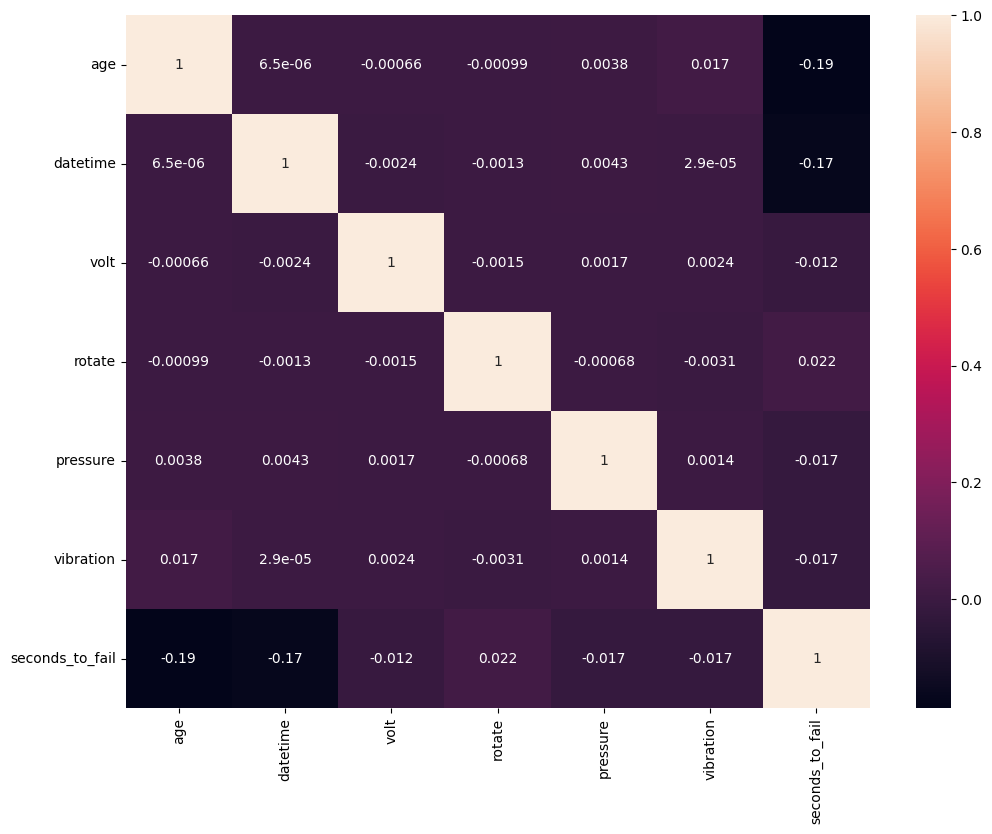

In [36]:
sns.heatmap(telemetry.drop(['machineID', 'model', 'failure'], axis = 1).corr(), annot=True).figure.set_size_inches(12, 9)

In [37]:
telemetry.columns

Index(['machineID', 'model', 'age', 'datetime', 'volt', 'rotate', 'pressure',
       'vibration', 'failure', 'seconds_to_fail'],
      dtype='object')

## Datetime conversion to timestamp

In [38]:
datetimes = telemetry['datetime']
timestamps = list()
for datetime_ in datetimes:
    timestamps.append(datetime.datetime.timestamp(datetime_))    
datetimes.shape[0], len(timestamps)

(876142, 876142)

In [39]:
telemetry['timestamp'] = timestamps
#telemetry.drop('datetime', axis=1, inplace=True)
#telemetry = telemetry[['timestamp', 'machineID', 'model', 'age', 'volt', 'rotate', 'pressure', 'vibration', 'failure', 'seconds_to_fail']]
telemetry

,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure,seconds_to_fail,timestamp
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure,345600,1.420092e+09
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,No Failure,342000,1.420096e+09
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,No Failure,338400,1.420099e+09
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,No Failure,334800,1.420103e+09
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,No Failure,331200,1.420106e+09
...,...,...,...,...,...,...,...,...,...,...,...
8756,100,model4,5,2016-01-01 02:00:00,179.438162,395.222827,102.290715,50.771941,No Failure,18000,1.451614e+09
8757,100,model4,5,2016-01-01 03:00:00,189.617555,446.207972,98.180607,35.123072,No Failure,14400,1.451617e+09
8758,100,model4,5,2016-01-01 04:00:00,192.483414,447.816524,94.132837,48.314561,No Failure,10800,1.451621e+09
8759,100,model4,5,2016-01-01 05:00:00,165.475310,413.771670,104.081073,44.835259,No Failure,7200,1.451624e+09


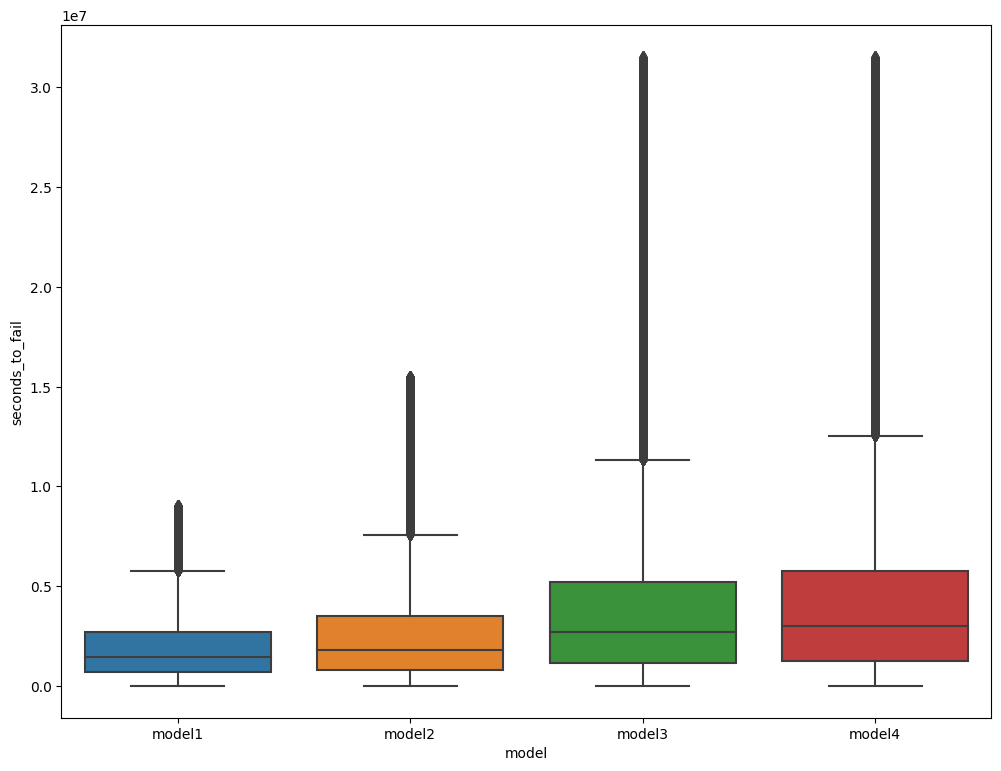

In [40]:
sns.boxplot(x=telemetry['model'], y=telemetry['seconds_to_fail'], order=['model1', 'model2', 'model3', 'model4']).figure.set_size_inches(12, 9)

In [41]:
telemetry['model'].value_counts()

model
model3    306644
model4    280363
model2    148945
model1    140190
Name: count, dtype: int64

## Choosing the machine model for the NN

In [42]:
model3_data = telemetry[telemetry['model'] == 'model3'].reset_index(drop=True)
model3_data

,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure,seconds_to_fail,timestamp
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure,345600,1.420092e+09
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,No Failure,342000,1.420096e+09
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,No Failure,338400,1.420099e+09
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,No Failure,334800,1.420103e+09
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,No Failure,331200,1.420106e+09
...,...,...,...,...,...,...,...,...,...,...,...
306639,93,model3,18,2016-01-01 02:00:00,202.858467,412.870855,85.569847,47.701614,No Failure,18000,1.451614e+09
306640,93,model3,18,2016-01-01 03:00:00,171.364527,459.880473,94.316793,47.592136,No Failure,14400,1.451617e+09
306641,93,model3,18,2016-01-01 04:00:00,182.867119,491.584480,90.332643,58.592710,No Failure,10800,1.451621e+09
306642,93,model3,18,2016-01-01 05:00:00,166.943545,352.047138,82.068954,46.256361,No Failure,7200,1.451624e+09


In [43]:
def create_time_step(data, machine_id):
    machine_id_data = data[data['machineID'] == machine_id]
    time_step = np.arange(1, machine_id_data.shape[0]+1)
    machine_id_data['time_step'] = time_step
    return machine_id_data

In [44]:
machineIDs = model3_data['machineID'].unique()
dataframes_with_time_step = []
for machine_id in machineIDs:
    dataframes_with_time_step.append(create_time_step(model3_data, machine_id))
len(dataframes_with_time_step)

35

In [45]:
model3_data = pd.DataFrame()
for df in dataframes_with_time_step:
    model3_data = pd.concat([model3_data, df])

### Removing unecessary columns

In [46]:
#model3_data = model3_data[['age', 'volt', 'rotate', 'pressure', 'vibration', 'seconds_to_fail']]
model3_data.drop(['model', 'failure', 'datetime', 'timestamp', 'machineID'], axis=1, inplace=True)
model3_data

,age,volt,rotate,pressure,vibration,seconds_to_fail,time_step
0,18,176.217853,418.504078,113.077935,45.087686,345600,1
1,18,162.879223,402.747490,95.460525,43.413973,342000,2
2,18,170.989902,527.349825,75.237905,34.178847,338400,3
3,18,162.462833,346.149335,109.248561,41.122144,334800,4
4,18,157.610021,435.376873,111.886648,25.990511,331200,5
...,...,...,...,...,...,...,...
306639,18,202.858467,412.870855,85.569847,47.701614,18000,8757
306640,18,171.364527,459.880473,94.316793,47.592136,14400,8758
306641,18,182.867119,491.584480,90.332643,58.592710,10800,8759
306642,18,166.943545,352.047138,82.068954,46.256361,7200,8760


## Data normalization

In [47]:
scaler = MinMaxScaler()

normalized_telemetry = pd.DataFrame(data=scaler.fit_transform(model3_data), columns=model3_data.columns)
normalized_telemetry.head()

,age,volt,rotate,pressure,vibration,seconds_to_fail,time_step
0,0.894737,0.510638,0.469652,0.472451,0.476569,0.010958,0.000000
1,0.894737,0.421045,0.439431,0.337821,0.448935,0.010844,0.000114
2,0.894737,0.475523,0.678413,0.183282,0.296461,0.010729,0.000228
3,0.894737,0.418248,0.330878,0.443188,0.411097,0.010615,0.000342
4,0.894737,0.385652,0.502013,0.463348,0.161269,0.010501,0.000457


## Splitting train, test and validations sets

### Calculating the sets size

In [48]:
train_size = math.ceil(normalized_telemetry.shape[0] * 0.7)
test_and_val_size = math.ceil((normalized_telemetry.shape[0] * 0.3) / 2)
print(f'Train size: {train_size}')
print(f'Test and validation size: {test_and_val_size}')

Train size: 214651
Test and validation size: 45997


### Selecting the samples

In [49]:
train_set = normalized_telemetry[:train_size]
validation_init_index = train_size + test_and_val_size

test_set = normalized_telemetry[train_size:validation_init_index].reset_index(drop=True)
val_set = normalized_telemetry[validation_init_index:].reset_index(drop=True)

train_set.shape, test_set.shape, val_set.shape

((214651, 7), (45997, 7), (45996, 7))

### X and y split

In [50]:
X_train = train_set.drop('seconds_to_fail', axis=1)
X_train = np.array(X_train)
y_train = train_set['seconds_to_fail']
y_train = np.array(y_train)

X_test = test_set.drop('seconds_to_fail', axis=1)
X_test = np.array(X_test)
y_test = test_set['seconds_to_fail']
y_test = np.array(y_test)

X_valid = val_set.drop('seconds_to_fail', axis=1)
X_valid = np.array(X_valid)
y_valid = val_set['seconds_to_fail']
y_valid = np.array(y_valid)

# List of models and its params

In [51]:
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [52]:
models = [
    ('ElasticNet', ElasticNet()),
    ('DecisionTree', DecisionTreeRegressor(random_state=42)),
    ('RandomForest', RandomForestRegressor(random_state=42)),
    ('KNN', KNeighborsRegressor()),
    ('GradientBoosting', GradientBoostingRegressor(random_state=42)),
    ('AdaBoost', AdaBoostRegressor(random_state=42))
]

In [53]:
dict(models)

{'ElasticNet': ElasticNet(),
 'DecisionTree': DecisionTreeRegressor(random_state=42),
 'RandomForest': RandomForestRegressor(random_state=42),
 'KNN': KNeighborsRegressor(),
 'GradientBoosting': GradientBoostingRegressor(random_state=42),
 'AdaBoost': AdaBoostRegressor(random_state=42)}

In [54]:
tuning_params = {
    'ElasticNet': {
        'alpha': np.logspace(np.log10(0.1), np.log10(10)),
        'l1_ratio': np.logspace(np.log10(0.1), np.log10(0.9)),
        'tol': np.logspace(np.log10(1e-4), np.log10(1e-6))
    },
    'DecisionTree': {
        'max_depth': np.arange(1, 20),
        'min_samples_split': np.arange(2, 20),
        'min_samples_leaf': np.arange(1, 10),
        'max_features': ['sqrt', 'log2']
    },
    'RandomForest': {
        'max_depth': [10, 20],
        'min_samples_split': [2, 20],
        'min_samples_leaf': [1, 10],
        'max_features': ['log2']
    },
    'KNN': {
        'n_neighbors': np.arange(2, 20),
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto'],
        'p': [1, 2]
    },
    'GradientBoosting': {
        'learning_rate': np.logspace(np.log10(0.01), np.log10(0.2)),
        'max_depth': np.arange(3, 10),
        'min_samples_split': np.arange(2, 20),
        'min_samples_leaf': np.arange(1, 10)
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 200, 500],
        'learning_rate': [0.01, 0.1, 1],
        'loss': ['linear', 'square', 'exponential']
    }
}

In [55]:
tuned_models, _ = tune_and_evaluate_models(X_train, X_valid, y_train, y_valid,
                                          dict(models[:]), tuning_params, mean_squared_error,
                                          n_iter=20, cv=TimeSeriesSplit(n_splits=5), seed=42)

Tuning Models: 100%|██████████| 6/6 [1:06:23<00:00, 663.95s/model]


In [56]:
solver = ga_stacking(
    X_train, y_train, X_valid, y_valid,
    tuned_models,
    ElasticNet(),
    10,
    mean_squared_error,
    metric_mode='error',
    seed=42,
    task='regressor'
)
solver.solve()
model = solver.best_model

Generations: 100%|██████████| 10/10 [19:12<00:00, 115.26s/gen]


In [57]:
y_pred = model.predict(X_test)

In [58]:
mean_squared_error(y_pred=y_pred, y_true=y_test)

0.011064521821610402

In [59]:
solver.best_combination

array([0, 1, 0, 0, 0, 1])

In [60]:
for tuned_model_name, tuned_model in tuned_models.items():
    y_pred = tuned_model.predict(X_test)
    # Print model name and its chosen parameters
    print(f'{"="*40}\nModel: {tuned_model_name}\n')
    
    # Extract the chosen parameters for the current model from `tuning_params`
    chosen_params = tuning_params.get(tuned_model_name, {})
    
    # Print only the chosen parameters
    if chosen_params:
        print("Chosen Parameters:")
        for param, values in chosen_params.items():
            print(f'  • {param}: {tuned_model.get_params().get(param, "Not Set")}')
    
    print()  # Newline after parameters
    
    # Print metrics with bullet points
    print(f'Metrics:\n'
          f'  • Mean Squared Error: {mean_squared_error(y_pred=y_pred, y_true=y_test)}\n')
    
    # Separator between models
    print("="*40)

Model: ElasticNet

Chosen Parameters:
  • alpha: 9.102981779915218
  • l1_ratio: 0.5747766808779754
  • tol: 4.71486636345739e-05

Metrics:
  • Mean Squared Error: 0.011064521821610402

Model: DecisionTree

Chosen Parameters:
  • max_depth: 17
  • min_samples_split: 9
  • min_samples_leaf: 1
  • max_features: sqrt

Metrics:
  • Mean Squared Error: 0.023536642762934306

Model: RandomForest

Chosen Parameters:
  • max_depth: 20
  • min_samples_split: 2
  • min_samples_leaf: 1
  • max_features: log2

Metrics:
  • Mean Squared Error: 0.02023706660547224

Model: KNN

Chosen Parameters:
  • n_neighbors: 2
  • weights: uniform
  • algorithm: auto
  • p: 1

Metrics:
  • Mean Squared Error: 0.028309433614634966

Model: GradientBoosting

Chosen Parameters:
  • learning_rate: 0.1769810349879349
  • max_depth: 9
  • min_samples_split: 3
  • min_samples_leaf: 5

Metrics:
  • Mean Squared Error: 0.021946521147457394

Model: AdaBoost

Chosen Parameters:
  • n_estimators: 200
  • learning_rate: 1
  • 